### Setup

In [5]:
import sys
!{sys.executable} -m pip install git+https://github.com/geomstats/geomstats.git
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/geomstats/geomstats.git to /private/var/folders/zk/7jfz5x6n6vbg7vwv_n6ckhkc0000gn/T/pip-req-build-y_n__zrd
  Running command git clone -q https://github.com/geomstats/geomstats.git /private/var/folders/zk/7jfz5x6n6vbg7vwv_n6ckhkc0000gn/T/pip-req-build-y_n__zrd
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/pyt

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs

gs.random.seed(2021)

INFO: Using numpy backend


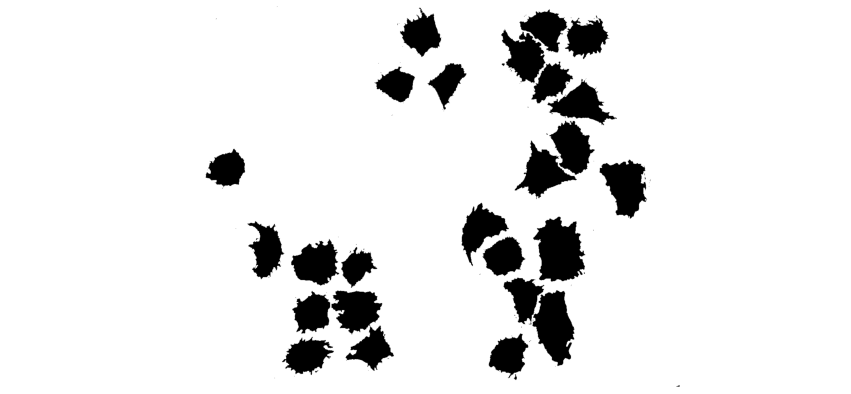

In [3]:
import cv2

img = cv2.imread('datasets/binary_image.tif')
plt.figure(figsize=(15, 7))
plt.axis('equal')
plt.axis('off')
plt.imshow(img)

In [4]:
def load_cells():
    """Load cell data.

    Returns
    -------
    cells : list of 2D discrete curves
        Each curve represents the boundary of a cell, their lengths
        are not necessarily equal.
    cell_lines : array of strings
        List of the cell lines of each cell.
    treatments : array of strings
        List of the treatments given to each cell.
    """
    with open("datasets/cells.txt") as cells_file:
        cells = cells_file.read().split('\n\n')
    for i, cell in enumerate(cells):
        cell = cell.split('\n')
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.array(curve)
    with open("datasets/cell_lines.txt") as cell_lines_file:
        cell_lines = gs.array(cell_lines_file.read().split('\n'))
    with open("datasets/treatments.txt") as treatments_file:
        treatments = gs.array(treatments_file.read().split('\n'))
    return cells, cell_lines, treatments

In [5]:
cells, cell_lines, treatments = load_cells()
print(f'Total number of cells : {len(cells)}')

Total number of cells : 650


In [6]:
for treatment in ["control", "cytd", "jasp"]:
    nb_dlm8 = gs.sum((treatments == treatment) & (cell_lines == "dlm8"))
    nb_dunn = gs.sum((treatments == treatment) & (cell_lines == "dunn"))
    print(f'{treatment} : {nb_dlm8} DLM8 and {nb_dunn} DUNN')

control : 114 DLM8 and 204 DUNN
cytd : 82 DLM8 and 93 DUNN
jasp : 62 DLM8 and 95 DUNN


In [7]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return interpolation

nb_sampling = 100

(1116.375, 1229.125, -283.2620000000003, -199.178)

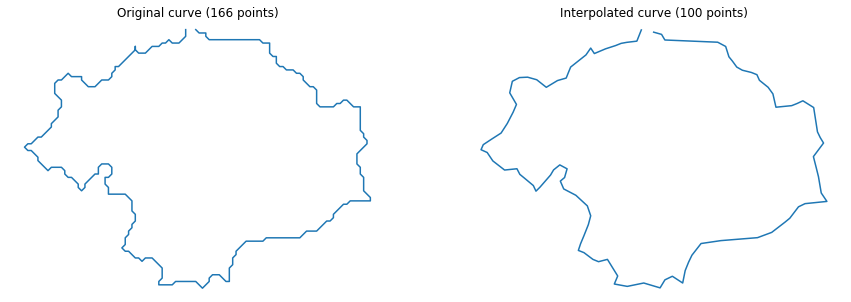

In [8]:
i = gs.random.randint(len(cells))
cell = cells[i]
cell_interpolation = interpolate(cells[i], nb_sampling)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell[:, 0], cell[:, 1])
plt.axis('equal')
plt.title(f"Original curve ({len(cell)} points)")
plt.axis('off')

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis('equal')
plt.title(f"Interpolated curve ({nb_sampling} points)")
plt.axis('off')

In [9]:
for i in range(len(cells)):
    cells[i] = interpolate(cells[i], nb_sampling)

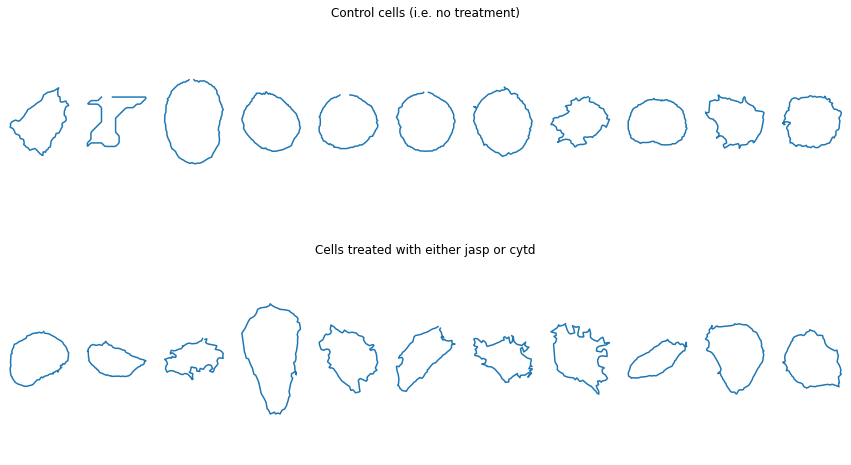

In [10]:
nb_cells = 11

control_i = gs.random.randint(0, 300, size=nb_cells)
jasp_i = gs.random.randint(500, 600, size=nb_cells)

fig = plt.figure(figsize=(15, 8))

for i in range(nb_cells):
    cell = cells[control_i[i]]
    fig.add_subplot(2, nb_cells, i + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Control cells (i.e. no treatment)")
    plt.axis('equal')
    plt.axis('off')
    
for i in range(nb_cells):
    cell = cells[jasp_i[i]]
    fig.add_subplot(2, nb_cells, i + nb_cells + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Cells treated with either jasp or cytd")
    plt.axis('equal')
    plt.axis('off')

In [11]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

m_ambient = 2
k_landmarks = nb_sampling

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

cells_preshape = preshape.projection(cells)

base_curve = cells_preshape[0]

def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift)%nb_sampling] for i in range(nb_sampling)]
        aligned = preshape.align(point=gs.array(reparametrized), base_point=gs.array(base_curve))
        distances[shift] = matrices_metric.norm(gs.array(aligned) - gs.array(base_curve))
    shift_min = gs.argmin(distances)
    reparametrized_min = [curve[(i + shift_min)%nb_sampling] for i in range(nb_sampling)]
    aligned_curve = preshape.align(point=gs.array(reparametrized_min), base_point=gs.array(base_curve))
    return aligned_curve

cells_shape = [exhaustive_align(curve, base_curve) for curve in cells_preshape]

Text(0.5, 1.0, 'Aligned curve')

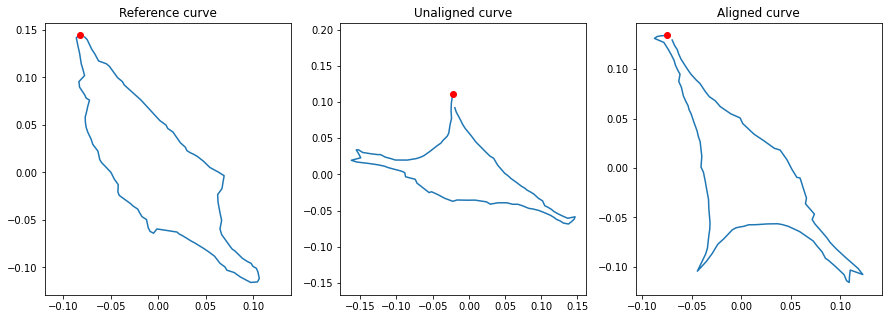

In [12]:
i = gs.random.randint(len(cells_shape))

base_cell = cells_preshape[0]
unaligned_cell = cells_preshape[i]
aligned_cell = cells_shape[i]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(base_cell[:, 0], base_cell[:, 1])
plt.plot(base_cell[0, 0], base_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Aligned curve")

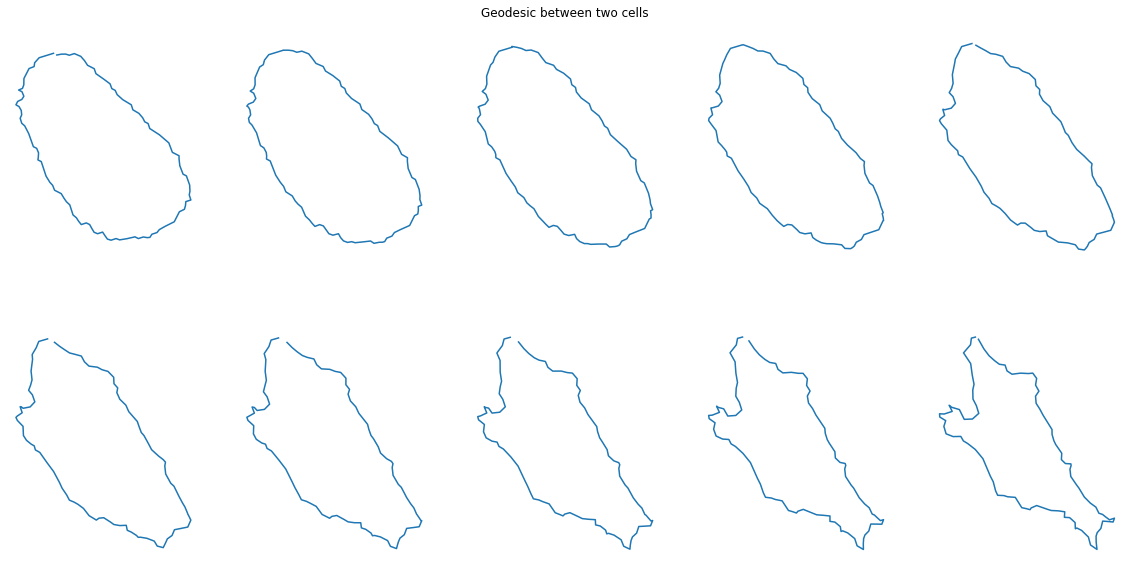

In [14]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.srv_metric
i, j = gs.random.randint(len(cells_shape), size=2)

geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between two cells")
plt.axis('off')

for i, curve in enumerate(points):
    fig.add_subplot(2, int(len(points)/2), i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')

In [15]:
N = len(cells_shape)
# srvs = [metric.square_root_velocity(cell) for cell in cells_shape]
dist_matrix = gs.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        # dist = curves.l2_metric(nb_sampling - 1).dist(cells_shape[i], cells_shape[j])
        try:
            dist = curves.srv_metric.dist(cells_shape[i], cells_shape[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
        except Exception as e:
            print("i:", i, "j:", j)

i: 0 j: 151
i: 1 j: 151
i: 2 j: 151
i: 3 j: 151
i: 4 j: 151
i: 5 j: 151
i: 6 j: 151
i: 7 j: 151
i: 8 j: 151
i: 9 j: 151
i: 10 j: 151
i: 11 j: 151
i: 12 j: 151
i: 13 j: 151
i: 14 j: 151
i: 15 j: 151
i: 16 j: 151
i: 17 j: 151
i: 18 j: 151
i: 19 j: 151
i: 20 j: 151
i: 21 j: 151
i: 22 j: 151
i: 23 j: 151
i: 24 j: 151
i: 25 j: 151
i: 26 j: 151
i: 27 j: 151
i: 28 j: 151
i: 29 j: 151
i: 30 j: 151
i: 31 j: 151
i: 32 j: 151
i: 33 j: 151
i: 34 j: 151
i: 35 j: 151
i: 36 j: 151
i: 37 j: 151
i: 38 j: 151
i: 39 j: 151
i: 40 j: 151
i: 41 j: 151
i: 42 j: 151
i: 43 j: 151
i: 44 j: 151
i: 45 j: 151
i: 46 j: 151
i: 47 j: 151
i: 48 j: 151
i: 49 j: 151
i: 50 j: 151
i: 51 j: 151
i: 52 j: 151
i: 53 j: 151
i: 54 j: 151
i: 55 j: 151
i: 56 j: 151
i: 57 j: 151
i: 58 j: 151
i: 59 j: 151
i: 60 j: 151
i: 61 j: 151
i: 62 j: 151
i: 63 j: 151
i: 64 j: 151
i: 65 j: 151
i: 66 j: 151
i: 67 j: 151
i: 68 j: 151
i: 69 j: 151
i: 70 j: 151
i: 71 j: 151
i: 72 j: 151
i: 73 j: 151
i: 74 j: 151
i: 75 j: 151
i: 76 j: 151
i: 77 j: 

In [16]:
dlm8_control_indexes = gs.where((cell_lines == "dlm8") & (treatments == "control"))[0]
dlm8_cytd_indexes = gs.where((cell_lines == "dlm8") & (treatments == "cytd"))[0]
dlm8_jasp_indexes = gs.where((cell_lines == "dlm8") & (treatments == "jasp"))[0]

dlm8_indexes = gs.concatenate((dlm8_jasp_indexes, dlm8_cytd_indexes, dlm8_control_indexes))
dlm8_matrix = dist_matrix[dlm8_indexes][:, dlm8_indexes]


dunn_control_indexes = gs.where((cell_lines == "dunn") & (treatments == "control"))[0] # indices to use
dunn_cytd_indexes = gs.where((cell_lines == "dunn") & (treatments == "cytd"))[0]
dunn_jasp_indexes = gs.where((cell_lines == "dunn") & (treatments == "jasp"))[0]

dunn_indexes = gs.concatenate((dunn_control_indexes, dunn_cytd_indexes, dunn_jasp_indexes))
dunn_matrix = dist_matrix[dunn_indexes][:, dunn_indexes]

dunn_control_matrix = dist_matrix[dunn_control_indexes][:, dunn_control_indexes]


In [17]:
print(dunn_control_matrix)
print(dunn_control_matrix.shape)
np.savetxt("datasets/dunn_control_matrix.txt", dunn_control_matrix)
# print(np.array(cells_shape).shape)

[[0.         0.64824496 0.81837053 ... 0.99860796 0.97071168 0.87376201]
 [0.64824496 0.         0.73575986 ... 0.860406   0.94290662 0.9254851 ]
 [0.81837053 0.73575986 0.         ... 0.99023615 1.09410381 1.09844986]
 ...
 [0.99860796 0.860406   0.99023615 ... 0.         1.23771934 1.15864755]
 [0.97071168 0.94290662 1.09410381 ... 1.23771934 0.         1.15992269]
 [0.87376201 0.9254851  1.09844986 ... 1.15864755 1.15992269 0.        ]]
(204, 204)


Running nSimplices

In [18]:
from nsimplices import *

### Run nSimplices method
feature_num = 40
dim_start = 1
dim_end = feature_num
dunn_control_matrix = np.loadtxt("datasets/dunn_control_matrix.txt")
print("dunn_control_matrix is:", dunn_control_matrix)
outlier_indices, subspace_dim, corr_dis_sq, corr_coord = \
    nsimplices(dunn_control_matrix, feature_num, dim_start, dim_end)

print("subspace dimension is:", subspace_dim)

dunn_control_matrix is: [[0.         0.64824496 0.81837053 ... 0.99860796 0.97071168 0.87376201]
 [0.64824496 0.         0.73575986 ... 0.860406   0.94290662 0.9254851 ]
 [0.81837053 0.73575986 0.         ... 0.99023615 1.09410381 1.09844986]
 ...
 [0.99860796 0.860406   0.99023615 ... 0.         1.23771934 1.15864755]
 [0.97071168 0.94290662 1.09410381 ... 1.23771934 0.         1.15992269]
 [0.87376201 0.9254851  1.09844986 ... 1.15864755 1.15992269 0.        ]]
med_height is: [0.62521705 0.59318397 0.57520489 0.56464145 0.5557683  0.5491625
 0.54287812 0.53847516 0.5367383  0.52801454 0.52621824 0.52235981
 0.52148589 0.51933918 0.51696174 0.51287243 0.51202618 0.50790745
 0.50671048 0.50498371 0.50302333 0.49909055 0.49817239 0.49757124
 0.49303755 0.49119145 0.4888824  0.48762897 0.48527084 0.48302332
 0.48083527 0.4781886  0.47696877 0.47292014 0.47174512 0.46964135
 0.46696481 0.46661511 0.46332906 0.46134399]
subspace_dim one is: 2
subspace_heights for dimension 2 is: [0.5763476

In [19]:
### Importance of dimension correction in higher dimension - Fig.4(A) height distribution 
num_point = dunn_control_matrix.shape[0]
hcolls = []
start_dim = 1
end_dim = 40
for dim in range(start_dim, end_dim+1):
    heights = nsimplices_all_heights(num_point, dunn_control_matrix, dim, seed=dim+1)
    hcolls.append(heights)

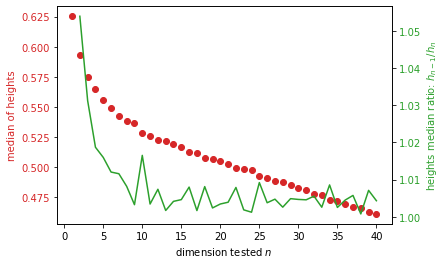

In [20]:
### Importance of dimension correction in higher dimension - Fig.4(B) dimensionality inference

# calculate median heights for tested dimension from start_dim to end_dim
h_meds = []
for hcoll in hcolls:
    h_meds.append(np.median(hcoll))

# calculate the ratio, where h_med_ratios[i] corresponds to h_meds[i-1]/h_meds[i]
# which is the (median height of dim (i-1+start_dim))/(median height of dim (i+start_dim))
h_med_ratios = []
for i in range(1, len(hcolls)):
    # print("dim", start_dim+i-1, "ratio is:", h_meds[i-1]/h_meds[i], h_meds[i-1], h_meds[i])
    h_med_ratios.append(h_meds[i-1]/h_meds[i])

# plot the height scatterplot and the ratios

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel(r'dimension tested $n$')
ax1.set_ylabel(r'median of heights', color = color)
ax1.scatter(list(range(start_dim, end_dim+1)), h_meds, color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'tab:green'
ax2.set_ylabel(r'heights median ratio: $h_{n-1}/h_n$', color = color)
ax2.plot(list(range(start_dim+1, end_dim+1)), h_med_ratios, color = color)
ax2.tick_params(axis ='y', labelcolor = color)
 
# Show plot
plt.show()

In [21]:
print(cells)
print(np.array(cells).shape)

[array([[ 916. , -603. ],
       [ 914. , -604.4],
       [ 915. , -609.4],
       [ 916. , -613.8],
       [ 917. , -620.2],
       [ 918. , -623.5],
       [ 919. , -627.4],
       [ 915.6, -631. ],
       [ 916. , -634.4],
       [ 919. , -638.9],
       [ 920. , -641. ],
       [ 922. , -642.2],
       [ 921. , -645.8],
       [ 920. , -650.3],
       [ 919.4, -652.4],
       [ 919.5, -655.5],
       [ 920. , -658.8],
       [ 921. , -661.7],
       [ 922. , -663.8],
       [ 923. , -665.9],
       [ 924. , -669. ],
       [ 927.1, -673.1],
       [ 928.2, -678.2],
       [ 929.3, -680. ],
       [ 932. , -682.8],
       [ 935. , -686. ],
       [ 937. , -690. ],
       [ 939.4, -693.4],
       [ 939.2, -697.8],
       [ 940. , -699.9],
       [ 947. , -705. ],
       [ 948.2, -706.2],
       [ 951.2, -708.2],
       [ 952.3, -710.3],
       [ 953.8, -712.8],
       [ 956.5, -714.5],
       [ 957.6, -719.6],
       [ 958.7, -721.7],
       [ 960.8, -722.8],
       [ 962.8, -720.2],

In [24]:
nb_cells = 3

dunn_control_cells = cells[dunn_control_indexes,:,:]

# fig = plt.figure(figsize=(15, 8))

for i in outlier_indices:
    cell = dunn_control_cells[i]
    # fig.add_subplot(2, nb_cells, i + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    # if i == nb_cells//2:
    #     plt.title("Outliers")
    plt.axis('equal')
    plt.axis('off')
    
for i in range(0,3):
    cell = dunn_control_cells[i]
    # fig.add_subplot(2, nb_cells, i + nb_cells + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    # if i == nb_cells//2:
    #     plt.title("Normal dunn control cells")
    plt.axis('equal')
    plt.axis('off')

TypeError: list indices must be integers or slices, not tuple